# ndrought Tutorial
a. stein 8.1.2023

In this notebook we will cover how to use the `ndrought` package to:
- convert non-USDM data to USDM categories
- create a drought network
- extract tracks or threads from the drought network

We will use data from SPI 180d over Washington state as our example, available on hydroshare.

## Setup

First we need to import some packages to use in this notebook. This tutorial assumes familiarity with Python 3 and these packages or the ability to easily learn how to use them.

In [50]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client, LocalCluster
import networkx as nx

Next we need to import our key scripts that we'll be using in this notebook.

In [51]:
import sys
# adjust this to have ndrought package included in your
# import directory
sys.path.append('../../')

import ndrought.drought_network as dnet
import ndrought.wrangle as dnw
import ndrought.plotting as ndplot

# lastly we'll be using os to check if this tutorial
# has already been ran and save you time in coming
# back if the files are already made
import os

Now we'll download data from hydroshare

In [52]:
if not os.path.exists('spi180d_tutorial.nc'):
    !wget https://www.hydroshare.org/resource/1ca38699cd1245b8bf9baf52bc99b85d/data/contents/spi180d_tutorial.nc

Let's now read in the data and take a look

In [53]:
spi_180d = xr.open_dataset('spi180d_tutorial.nc')
spi_180d

<xarray.Dataset>
Dimensions:  (lat: 84, lon: 188, day: 1533)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 2000-01-05 2000-01-10 ... 2020-12-30
Data variables:
    crs      int64 ...
    spi      (day, lat, lon) float32 ...

Now we need to do some reformatting of the data to get it compatible with our scripts

In [54]:
# time is the assumed temporal variable
spi_180d_da = spi_180d['spi'].rename({'day':'time'})
spi_180d_da

<xarray.DataArray 'spi' (time: 1533, lat: 84, lon: 188)>
[24209136 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * time     (time) datetime64[ns] 2000-01-05 2000-01-10 ... 2020-12-30
Attributes:
    units:              
    description:        Standardized Precipitation Index
    long_name:          spi180d
    standard_name:      spi180d
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    Clipping:           original data was clipped to Washington using http://...
    grid_mapping:       crs

## Convert to USDM Categories

Now that that is setup, let's convert the data from SPI's scale to USDM categories, which are as follows:

D0 : 21 to 30 p    
D1 : 11 to 20 p    
D2 : 6 to 10 p    
D3 : 3 to 5 p    
D4 : 0 to 2 p

In [55]:
percentiles = [30, 20, 10, 5, 2]
if not os.path.exists('spi180d_usdmcat.nc'):
    # note that this can take about 2 minutes to run
    spi_180d_usdmcat = dnw.dm_to_usdmcat_multtime(spi_180d_da, percentiles)
    spi_180d_usdmcat.to_netcdf('spi180d_usdmcat.nc')
else:
    spi_180d_usdmcat = xr.open_dataset('spi180d_usdmcat.nc')['spi']

Now we can check that our values are in USDM Categories through a little histogram:

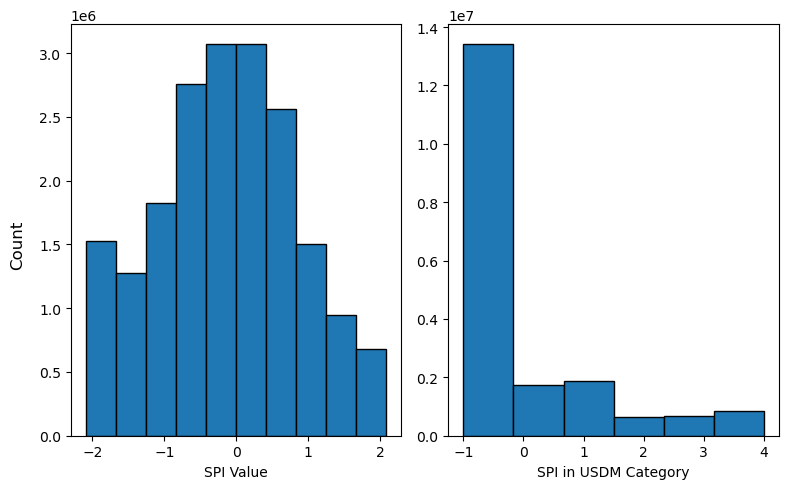

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(8,5))

axs[0].hist(spi_180d_da.values.ravel(), edgecolor='k')
axs[1].hist(spi_180d_usdmcat.values.ravel(), bins=6, edgecolor='k')

fig.supylabel('Count')
axs[0].set_xlabel('SPI Value')
axs[1].set_xlabel('SPI in USDM Category')

plt.tight_layout()

We can see that we've gone from a roughly +/- 2 range to a -1 to 4 category range that are the USDM categories. Most of the data is in the -1 bin because that includes our wet conditions that SPI considers but USDM categories do not.

Now we need to reproject to an Albers Equal Area projection for doing computations on drought area that is creating the drought network and extracting drought tracks.

First off, since we have a dataarray, we need to write it's crs

In [57]:
spi_180d.crs.attrs['crs_wkt']

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

We can see that EPSG:4326 was the last projection this was converted to, so let's write that down.

In [58]:
spi_180d_usdmcat = spi_180d_usdmcat.rio.write_crs('EPSG:4326', inplace=True)

Now I want to reproject it to EPSG:5070 to have an Albers Equal Area projection over Washington state.

In [59]:
spi_180d_usdmcat_reproj = spi_180d_usdmcat.rio.reproject('EPSG:5070')

Let's save that out

In [60]:
# need to remove this grid_mapping 
# attribute for the function to save out properly
del spi_180d_usdmcat_reproj.attrs['grid_mapping']
# also need to remove the crs we just assigned it to 
# preserve the netcdf as a singular variable that
# our drought tracks will want later
del spi_180d_usdmcat_reproj['crs']
if not os.path.exists('spi180d_usdmcat_EPSG5070.nc'):
    spi_180d_usdmcat_reproj.to_netcdf('spi180d_usdmcat_EPSG5070.nc')

Wonderful. Now that we have that sorted we can move on to creating our drought network.

## Create Drought Network

Let's compute how big a cell is and double check the units we're working with

In [61]:
spi_180d_usdmcat_reproj.x.attrs['units']

'metre'

Now we can divide any of our computations by `1e3` to get kilometers

In [62]:
x_spacing = np.abs(spi_180d_usdmcat_reproj.x.values[1] - spi_180d_usdmcat_reproj.x.values[0])/1e3 #km
x_spacing

3.4502829917380584

In [63]:
y_spacing = np.abs(spi_180d_usdmcat_reproj.y.values[1] - spi_180d_usdmcat_reproj.y.values[0])/1e3 # km
y_spacing

3.4502829917380584

In [64]:
cell_area = np.round(np.abs(x_spacing*y_spacing), 1)
cell_area

11.9

So a cell is roughly 11.9 square-kilometers

Computing the drought network takes an area threshold in number of cells, so we need to divide whatever our desired area is in square-kilometers by our cell area to get the number of cells we need to set our threshold at.

In [65]:
# adding one since I want to round up
area_threshold = np.int64(25000/cell_area)+1 
area_threshold

2101

Now we can create our drought network. Notice that we can save these out in a pickle for easy access later.

In [66]:
# around 3 minutes to run if area threshold is 25000 km2
if not os.path.exists('spi180d_dnet.pickle'):
    spi180d_dnet = dnet.DroughtNetwork(spi_180d_usdmcat_reproj.values, area_threshold=area_threshold)
    spi180d_dnet.pickle('spi180d_dnet.pickle')
else:
    spi180d_dnet = dnet.DroughtNetwork.unpickle('spi180d_dnet.pickle')

With our network we can take a peak at what it looks like! (Note that for larger networks they may be too big to plot).

In [81]:
# first we need to get the plotting elements
# for our network
topog, pos = spi180d_dnet.get_nx_network()

Let's look a little closer at the function we just called

In [83]:
spi180d_dnet.get_nx_network?

Signature:
spi180d_dnet.get_nx_network(
    id=None,
    start_time=None,
    end_time=None,
    adj_dict=None,
)
Docstring:
Gets topography and positions for networkx.

Used for plotting in networkx.draw_networkx

Parameters
----------
id, (optional): int
    If you would like to select out an id thread at the
    same time, this can be given to use 
    get_chronological_future_thread to time slice through.
start_time, (optional): int
    What time to start the slice at, inclusive. If None
    is given, then the time of the first node in the
    DroughtNetwork is used.
end_time, (optional): int
    What time to end the slice at, inclusive. If None is
    given, then the time of the last node in the 
    DroughtNetwork is used.
adj_dict, (optional): dict
    Use an alternative adjacency dictionary to the
    whole network. Defaults to using whole network if None
    is given. This overrules selecting by id, start_time, or
    end_time.

Returns
-------
topog, pos
    Positions generat

We can see that we can provide an `id` or time to slice the data as we desire. Feel free to try it out and replot the following cell:

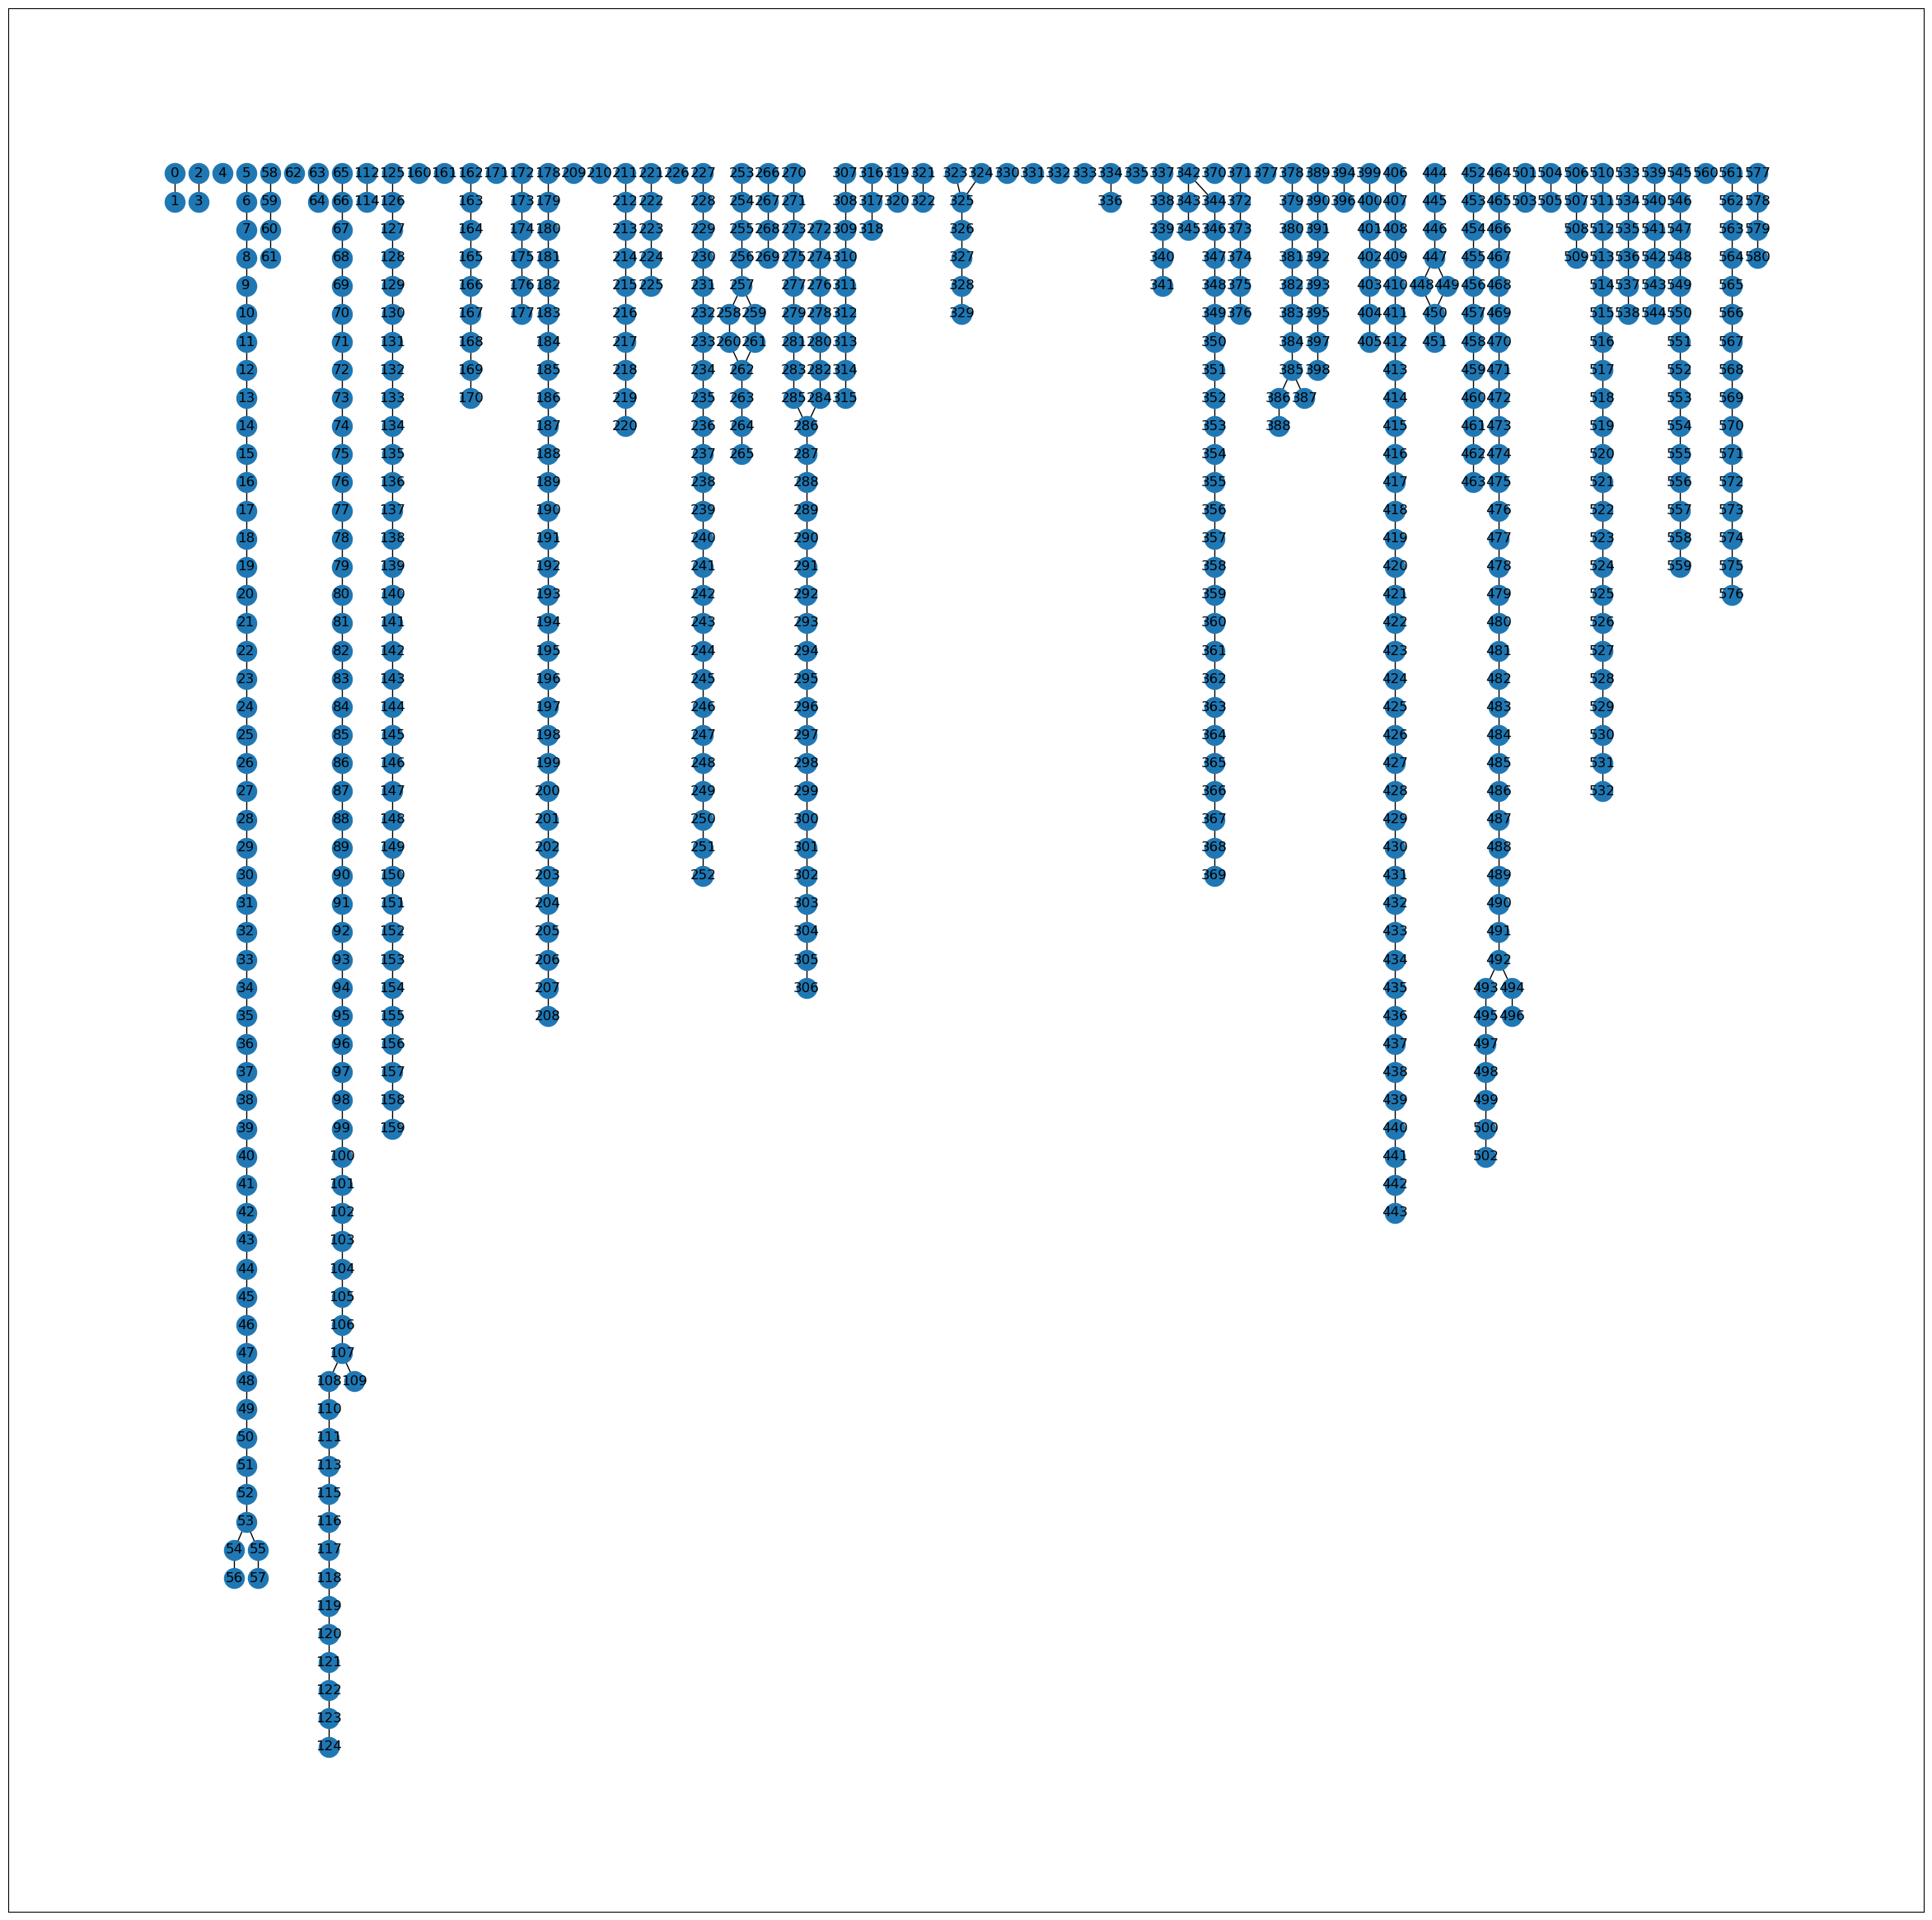

In [82]:
fig, ax = plt.subplots(figsize=(30,30))

nx.draw_networkx(topog, pos, ax=ax)

You might need to open the image itself/zoom in to better view this, but this is how our drought events are linked to each other. We can see there are splits and mergers that occur and see where there are independent threads. We can also spot how there are several origins with only a singular event in the thread (we'll filter these out later).

For more on how to tinker with the drought network, check out the `what_is_dnet.ipynb` tutorial!

Now that we have our network formed, we can extract threads or tracks from the network!

## Extract Drought Tracks

Extracting our drought tracks uses a configuration file to keep everything together and simplify the number of functions you have to call to get out tracks.

### Create Configuration file

This file will point to all the other files that will be used and set our thresholds.

In [18]:
config_path = 'tutorial_config.yaml'
track_path = 'spi180d_tracks.pickle'

if not os.path.exists(config_path):
    dnw.write_config(
            config_path=config_path,
            data_dir='spi180d_usdmcat_EPSG5070.nc',
            dnet_dir='spi180d_dnet.pickle',
            track_dir=track_path,
            log_dir='tutorial_logs',
            metric_thresh=1,
            area_thresh=area_threshold,
            ratio_thresh=0.2
        )

`metric_thresh` is the threshold we gave the drought network to create a binary drought/no-drought map. We specify this in the configuration file because it will automatically create a drought network if it doesn't already exist.

`area_thresh` is our area threshold, how small a drought blob can be and still be considered a drought event.

`ratio_thresh` is our ratio or continuation threshold, what area ratio must the blob at t+1 of the blob at t be, where t is a time index. Setting it to 0.2 means that in order for two blobs to be considered part of the same track, the second blob must be at least 0.2 times the size of the first blob to continue the track. Note that this was not specified in the drought network because the drought network does not filter based on this threshold, only when we extract our tracks do we employ this threshold.

### Create a dask client for parallelism

Next we'll need a dask client since this was setup for parallelism to speed things up. If you do not want to run in parallel, simply change the number of workers (`n_workers`) to 1.

In [19]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)

client = Client(cluster)
print(client.dashboard_link)

/pool0/data/steinadi/.conda/envs/ndrought/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34583 instead
  warnings.warn(


http://127.0.0.1:34583/status


### Extract our tracks from the network

Now we can extract our tracks from the network with this simple function:

In [20]:
dnw.compute_drought_tracks(config_path, client)

Lazy Data Load
... Data ready
Loading spi ...
... Done


45 Valid Origins Found



100%|██████████| 45/45 [00:00<00:00, 377487.36it/s]


Extracting Tracks from drought_network


/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle.py:1401: RuntimeWarning: invalid value encountered in scalar divide
  color_list = [cmap(np.round((t-t_min)/(t_max-t_min), 4))[:-1] for t in t_list]
/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle.py:1401: RuntimeWarning: invalid value encountered in scalar divide
  color_list = [cmap(np.round((t-t_min)/(t_max-t_min), 4))[:-1] for t in t_list]
/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle.py:1401: RuntimeWarning: invalid value encountered in scalar divide
  color_list = [cmap(np.round((t-t_min)/(t_max-t_min), 4))[:-1] for t in t_list]
/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle.py:1401: RuntimeWarning: invalid value encountered in scalar divide
  color_list = [cmap(np.round((t-t_min)/(t_max-t_min), 4))[:-1] for t in t_list]
Reshaping and Packaging: 100%|██████████| 45/45 [00:00<00:00

Note that in the package, there is also `extract_drought_tracks` and `collect_drought_tracks`. These are children functions of `compute_drought_tracks`, so we want to use that one as the parent that'll handle both of them.

So what did we just create? We extracted the following attributes as tracks:
- x coordinate
- y coordinate
- u vector
- v vector
- time coordinate
- color as a function of relative time
- transparency as a function of similarity
- size of blobs at x,y
- size of blobs at x+u, y+v
- id of drought blobs

With this we can compute a variety of statistics about our drought metric.

### Read in our tracks

Here we have our drought-track-dictionary, or dtd for short:

In [21]:
spi180d_dtd = dnw.convert_pickle_to_dtd(track_path)

I'm going to prune the tracks so that we only have one track per termination point, e.g. enforcing our singular-termination point filter as described in the paper.

In [22]:
spi180d_dtd = dnw.prune_tracks(spi180d_dtd)

If you do not do this step, then you will have all the possible paths, which includes paths terminating at the same point. This can lead to an over representation of paths that have many splits and mergers but ultimately lead to the same end point. We prune them to account for this over representation in our statistics.

We also can remove singular drought events that occur from the ratio threshold cutting off the rest of the track.

In [23]:
spi180d_dtd = dnw.remove_singulars(spi180d_dtd)

If you do not remove these you might have some drought threads with only a single time step in them, which can result in infinite thread velocities when dividing distance traveled by a change in time of 0.

Let's take a look at our keys we get

In [24]:
spi180d_dtd.keys()

dict_keys(['x', 'y', 'u', 'v', 't', 'c', 'a', 's', 'sf', 'id'])

Each key corresponds to the list previously mentioned:
- x : x coordinate
- y : y coordinate
- u : u vector
- v : v vector
- t : time coordinate
- c : color as a function of relative time
- a : transparency as a function of similarity
- s : size of blobs at x,y
- sf : size of blobs at x+u, y+v
- id: id of drought blobs

The dictionary is composed of a list of tracks that follow the same order for each key. So if I wanted to get the x,y coordinates of the first track listed, I'd do:

In [25]:
[(x, y) for x, y in zip(spi180d_dtd['x'][0], spi180d_dtd['y'][0])]

[(-1883756.3298131851, 2976492.420834431),
 (-1901456.9540081872, 2981808.376515392),
 (-1907071.8887067072, 2985178.9239489436),
 (-1934820.9529298074, 2982140.435874956),
 (-1886539.1511335566, 2979155.0073570935),
 (-1863406.1964689912, 2973413.613322331),
 (-1865710.5316291978, 2974278.7111891755),
 (-1866446.3336371651, 2974067.058281361),
 (-1871114.3848752757, 2978271.518005204),
 (-1866018.3775166466, 2975563.7922550417),
 (-1859154.6309266146, 2969736.855830309),
 (-1850423.3865040527, 2959442.408736216),
 (-1859436.4160562805, 2968931.99153534),
 (-1862608.152627284, 2972143.027928107),
 (-1863388.43714248, 2972388.037500393),
 (-1861002.1375586307, 2970859.6208958095),
 (-1864912.8663189062, 2973244.7971008485),
 (-1865772.3526483173, 2974051.7790258946),
 (-1866268.444820682, 2974005.9782059467),
 (-1864846.524243549, 2973422.155058658),
 (-1864968.9785352743, 2973965.572963861),
 (-1856189.6076181822, 2965961.481312031),
 (-1853472.6594141568, 2963573.879110749),
 (-184972

And if I call `len` on one of the dtd lists, then I can see how many tracks there are

In [26]:
len(spi180d_dtd['x'])

33

If we want our basic summary statistics described in the paper (lifetime, distance, displacement, average velocity, similarity, size), we can use a summarizing function:

In [27]:
# need to pass in how many days per time increment.
# for spi it's pentads, or 5 days
spi180d_summary, spi180d_summary_grouped = dnw.compute_track_summary_characterization(spi180d_dtd, 5)

In [28]:
spi180d_summary.head()

,lifetime,distance,displacement,average velocity,similarity,xy_size,uv_size
0,245,6.715807e+05,131290.457655,2741.145719,0.933859,"[6389, 9830, 10021, 9201, 11104, 12850, 12705,...","[9830, 10021, 9201, 11104, 12850, 12705, 12726..."
1,10,5.537969e+04,34973.811416,5537.968562,0.676662,"[2696, 3684, 2185]","[3684, 2185, 3099]"
2,275,1.004745e+06,226118.992765,3653.619799,0.881564,"[3538, 4748, 4358, 5721, 5583, 5290, 4709, 506...","[4748, 4358, 5721, 5583, 5290, 4709, 5069, 514..."
3,165,6.825288e+05,58222.727857,4136.538100,0.824749,"[2917, 4461, 2604, 2309, 4408, 3482, 2880, 230...","[4461, 2604, 2309, 4408, 3482, 2880, 2302, 498..."
4,35,1.926762e+05,123830.595082,5505.033009,0.821872,"[4069, 4532, 4580, 5564, 4307, 5179, 4151, 2233]","[4532, 4580, 5564, 4307, 5179, 4151, 2233, 2429]"


The second output from that function is a groupby object grouped by `[0, 30, 60, 90, 180, 365, 730, 1825, 7*1163]`

In [29]:
spi180d_summary_grouped

That way we can do things like get the mean lifetime per temporal bin:

In [45]:
spi180d_summary_grouped['lifetime'].mean()

lifetime
(0, 30]          17.000000
(30, 60]         40.833333
(60, 90]         67.500000
(90, 180]       143.125000
(180, 365]      260.000000
(365, 730]             NaN
(730, 1825]            NaN
(1825, 8141]           NaN
Name: lifetime, dtype: float64

Now what if we want to get latitudes and longitudes out of our tracks instead? Well we can use `dnw.transform_points`

In [31]:
dnw.transform_points?

Signature:
dnw.transform_points(
    x,
    y,
    inproj=<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
,
    outproj=<Geographic 2D CRS: EPSG:4326>
Nam

We can see the default arguments are expecting coordinates of `EPSG:5070` and tranforming them into `EPSG:4326`, but we could replace them with any projections.

In [32]:
lat, lon = dnw.transform_points(spi180d_dtd['x'][0], spi180d_dtd['y'][0])
print(lat, lon)

[47.52567789 47.53000756 47.54599485 47.45252791 47.54234788 47.54669232
 47.54885526 47.5452782  47.57106953 47.55937022 47.5244843  47.45478021
 47.51678666 47.53745005 47.53776531 47.52998469 47.54168496 47.54672588
 47.54516153 47.5433914  47.54785622 47.4983845  47.48382993 47.4559533
 47.4668594  47.45866541 47.46341459 47.44351498 47.45204784 47.45314676
 47.46873026 47.4621926  47.45107498 47.48938667 47.48816695 47.41702099
 47.45613633 47.50477492 47.49644928 47.49438091 47.51101778 47.51210589
 47.49339605 47.47986192 47.44061267 47.50347239 47.54660508 47.56089581
 47.49989287 47.49989287 48.3037542  46.7508183 ] [-121.14539992 -121.38916005 -121.47237692 -121.81440449 -121.19003476
 -120.87554907 -120.90788018 -120.91653536 -120.99044639 -120.91620022
 -120.80881619 -120.66263007 -120.8096671  -120.8610384  -120.87182065
 -120.83618994 -120.89417806 -120.9078922  -120.91405903 -120.89393855
 -120.89735678 -120.75818879 -120.71546634 -120.65349706 -120.67526542
 -120.653928

/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle.py:1074: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(inproj,outproj,x,y)


Let's now plot these across the landscape

In [33]:
track_index = 6

x = spi180d_dtd['x'][track_index]
y = spi180d_dtd['y'][track_index]
lat, lon = dnw.transform_points(x, y)

timeline = spi180d_dtd['t'][track_index]

/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle.py:1074: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(inproj,outproj,x,y)


Now we're going to want to get out the individual drought events (blobs) that make up each element of the track

In [34]:
# since the nodes list in the drought network is constructed in order,
# the index will equal the id
drought_events = [spi180d_dnet.nodes[id] for id in spi180d_dtd['id'][track_index]]
# here we can double check that
for id, event in zip(spi180d_dtd['id'][track_index], drought_events):
    print(f'id: {id}; node: {event}')

id: 178; node: time: 370, id: 178, futures: [179]
id: 179; node: time: 371, id: 179, futures: [180]
id: 180; node: time: 372, id: 180, futures: [181]
id: 181; node: time: 373, id: 181, futures: [182]
id: 182; node: time: 374, id: 182, futures: [183]
id: 183; node: time: 375, id: 183, futures: [184]
id: 184; node: time: 376, id: 184, futures: [185]
id: 185; node: time: 377, id: 185, futures: [186]
id: 186; node: time: 378, id: 186, futures: [187]
id: 187; node: time: 379, id: 187, futures: [188]
id: 188; node: time: 380, id: 188, futures: [189]
id: 189; node: time: 381, id: 189, futures: [190]
id: 190; node: time: 382, id: 190, futures: [191]
id: 191; node: time: 383, id: 191, futures: [192]
id: 192; node: time: 384, id: 192, futures: [193]
id: 193; node: time: 385, id: 193, futures: [194]
id: 194; node: time: 386, id: 194, futures: [195]
id: 195; node: time: 387, id: 195, futures: [196]
id: 196; node: time: 388, id: 196, futures: [197]
id: 197; node: time: 389, id: 197, futures: [198]


The blob identification software that we use outputs coordinates in an index-space, which is what is stored under `coords` in our drought network. To make it plottable, we need to transform our coordinates to coordinate-space first.

Let's take a look at what our function `to_xy` requires to transform our coordinates

In [35]:
dnw.to_xy?

Signature: dnw.to_xy(coord, coord_meta)
Docstring:
Converst index space to x,y coordinates.

Parameters
----------
coord
    Expects (y, x) in index space.
coord_meta
    Expects (y_min, y_max, y_spacing, x_min, 
    x_max, x_spacing).

Returns
-------
tuple
    (x,y) in coordinate space.
File:      /pool0/data/steinjao/drought/drought_impact/ndrought/wrangle.py
Type:      function

`to_xy` expects an argument called `coord_meta`, this stores meta information about the coordinate space we want to transform into, so we'll need ton construct it as follows:

In [36]:
x_all = spi_180d_usdmcat_reproj.x.values
y_all = spi_180d_usdmcat_reproj.y.values

y_min = np.min(y_all)
y_max = np.max(y_all)
y_spacing = np.abs(y_all[1] - y_all[0])

x_min = np.min(x_all)
x_max = np.max(x_all)
x_spacing = np.abs(x_all[1] - x_all[0])

coord_meta = (y_min, y_max, y_spacing, x_min, x_max, x_spacing)

Now we can go through and get our coordinates into xy-space, then use our `transform_points` function that we used earlier to get it into latlon-space:

In [37]:
de_xy = [[dnw.to_xy(coord, coord_meta) for coord in drought_event.coords] for drought_event in drought_events]
de_xy = [np.array(de) for de in de_xy]
de_latlon = [dnw.transform_points(de[:, 0], de[:, 1]) for de in de_xy]

/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle.py:1074: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(inproj,outproj,x,y)
/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle.py:1074: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(inproj,outproj,x,y)
/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle.py:1074: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(inproj,outproj,x,y)
/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle.py:1074: FutureWarning: This function is deprecated. See: https://pyproj4.git

Wonderful. Let's now take a look at those centroids

/tmp/ipykernel_2083486/1063731566.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/tmp/ipykernel_2083486/1063731566.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Time Index')


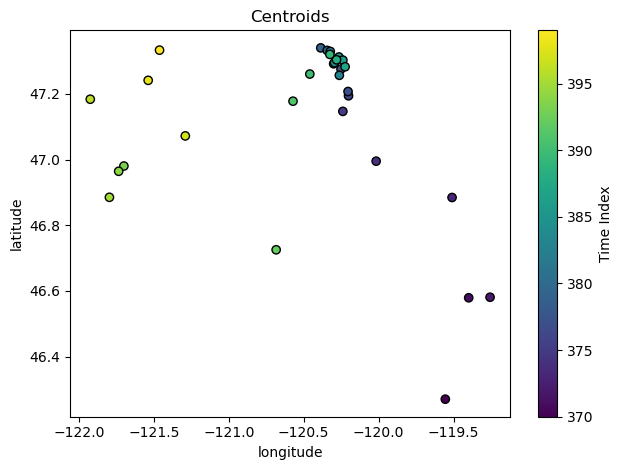

In [38]:
fig, ax = plt.subplots()

ax.scatter(lon, lat, c=spi180d_dtd['c'][track_index], edgecolor='k')

cmap = plt.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=timeline[0], vmax=timeline[-1])

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.set_title('Centroids')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Time Index')

plt.tight_layout()

We can see the path the drought centroids take by following the color gradient as it gets brighter (hence why it's stored as `c` in our `dtd`).

But centroids aren't the only thing we're interested in, we want to see the drought blobs that they represent. So let's go ahead and plot those as well.

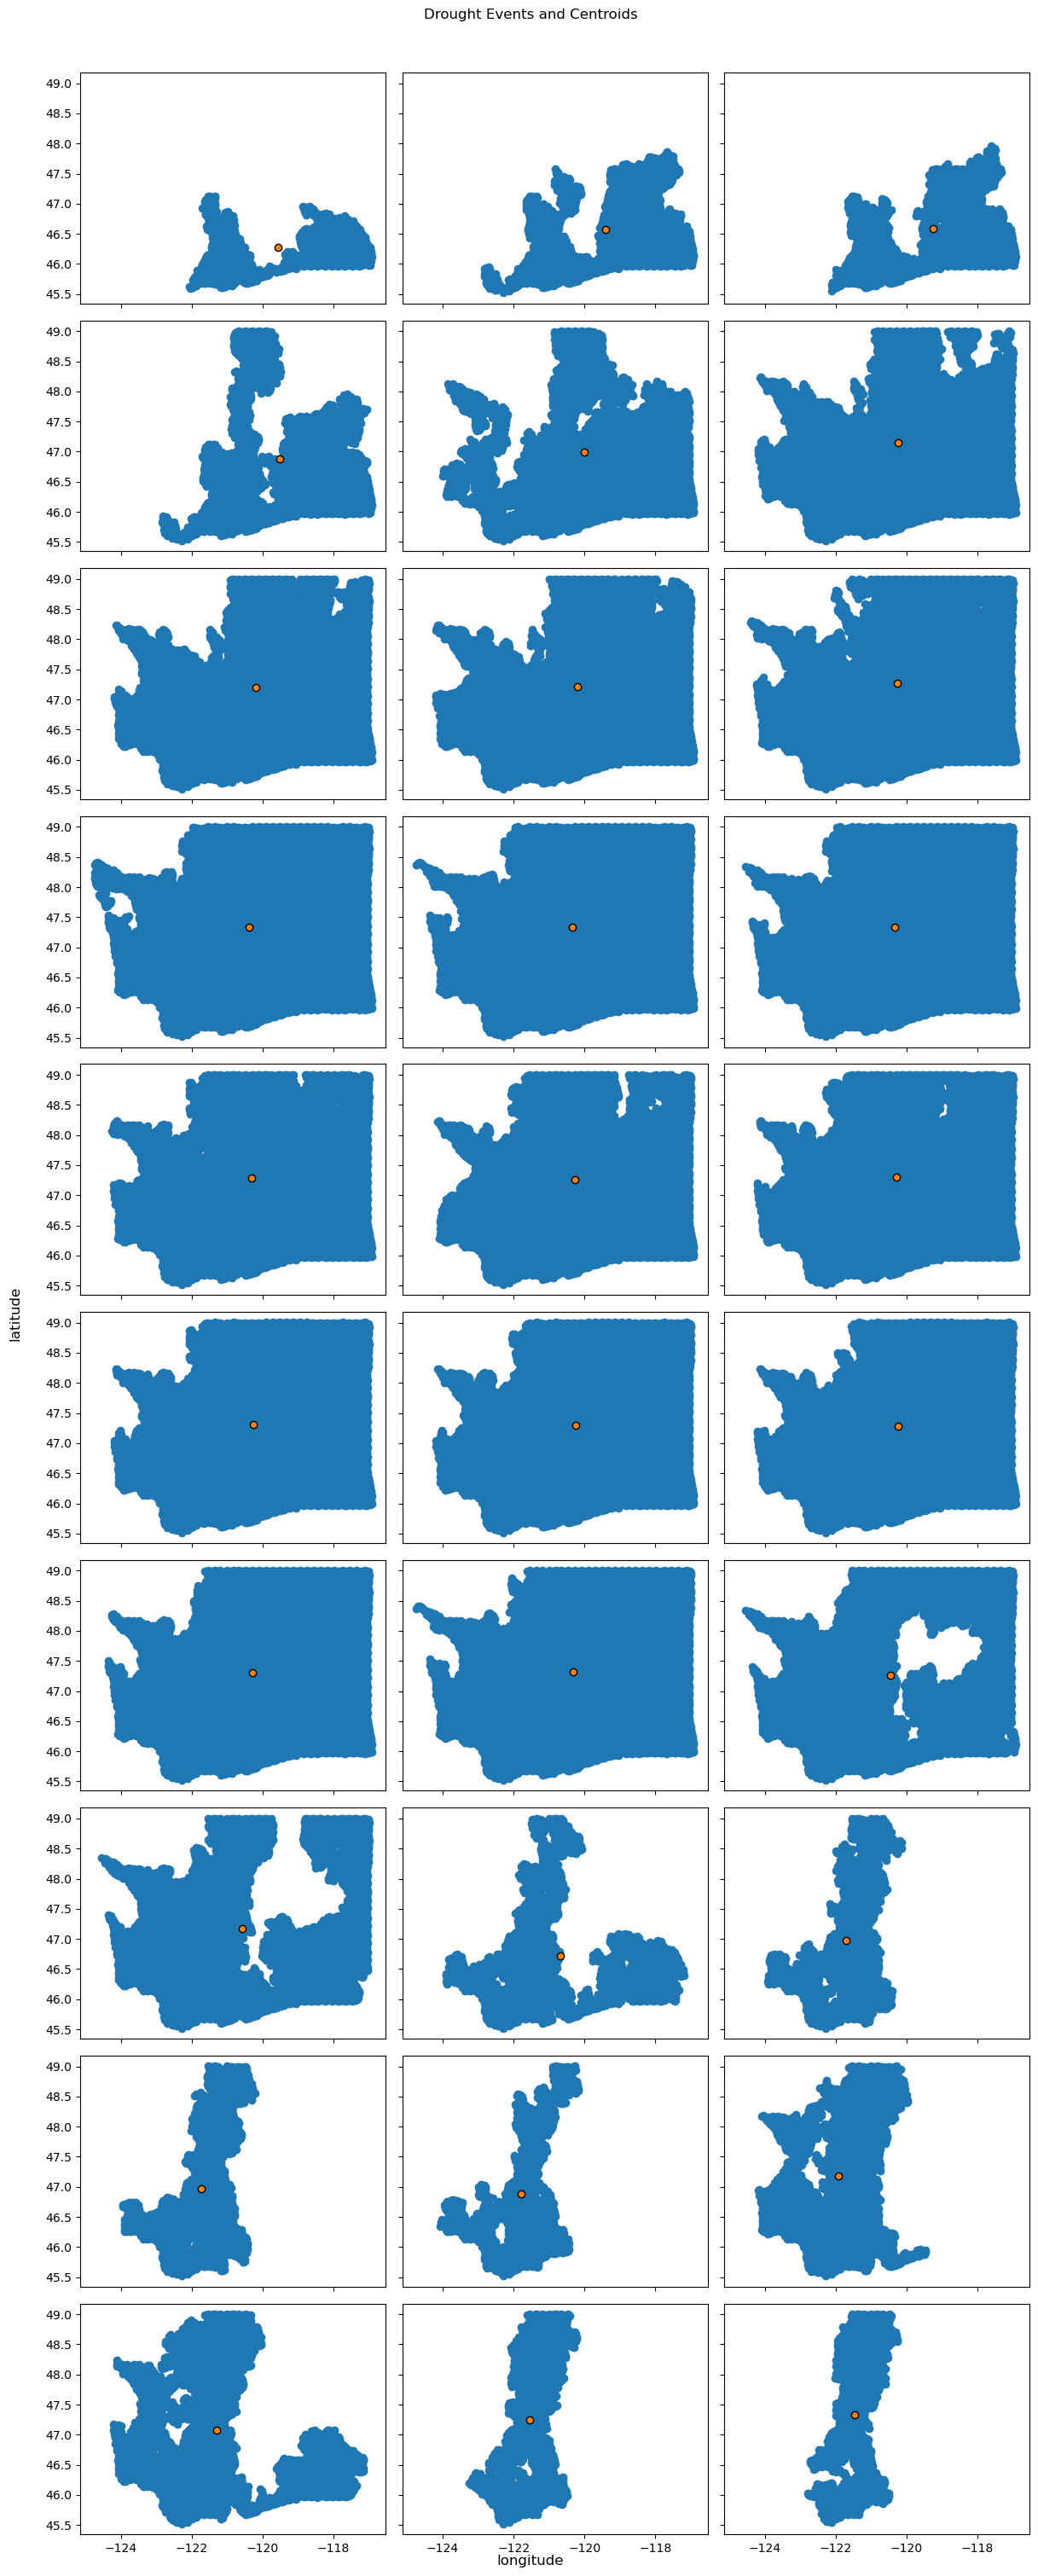

In [39]:
fig, axs = plt.subplots(10, 3, figsize=(12, 30), sharex=True, sharey=True)

for ax, de, sub_lon, sub_lat in zip(axs.ravel(), de_latlon, lon, lat):
    # notice the ordering here that we are storing
    # drought events as lat lon pairs, which means
    # we need to plot the arguments in reverse order
    # to get horizontal and vertical coordinates
    # properly arranged
    ax.scatter(de[1], de[0])
    ax.scatter(sub_lon, sub_lat, edgecolor='k')

fig.supxlabel('longitude')
fig.supylabel('latitude', x=-0.01)
fig.suptitle('Drought Events and Centroids', y=1.01)

plt.tight_layout()

Notice how the drought events that we get out are point clouds, not geometric objects.

Let's take a look at those events with a little more context, we'll add in the SPI180d in USDM categories as a basemap

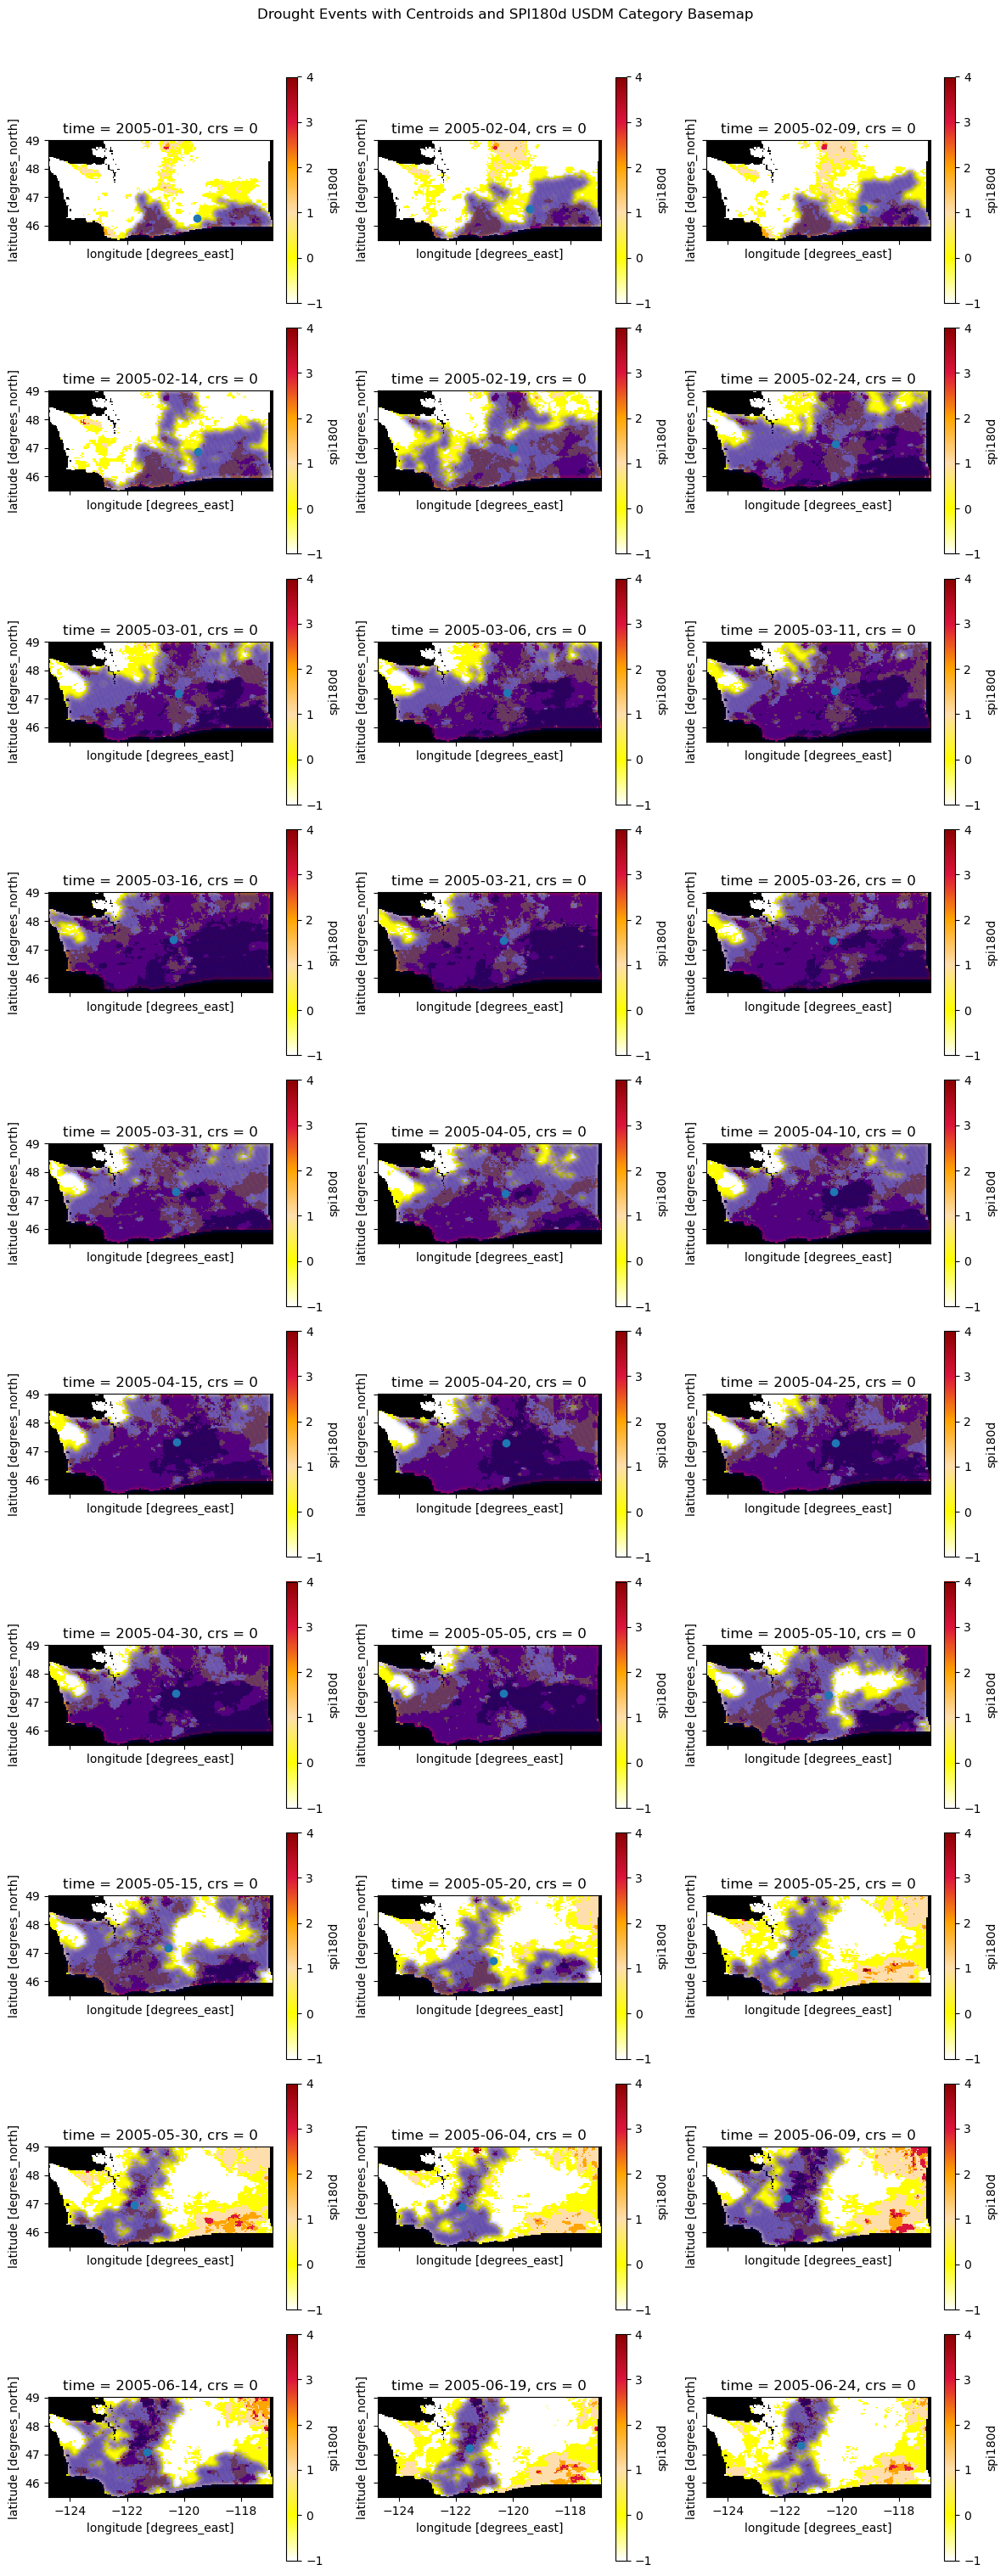

In [40]:
fig, axs = plt.subplots(10, 3, figsize=(12, 30), sharex=True, sharey=True)
axs_list = axs.ravel()

for i, t in enumerate(timeline):
    ax = axs_list[i]
    
    t_frame = spi_180d_usdmcat.isel(time=t)
    t_frame.plot(ax=ax,cmap=ndplot.usdm_cmap(), vmin=-1, vmax=4)
    ax.set_aspect('equal')
    ax.set_facecolor('k')

for de, ax, sub_lon, sub_lat in zip(de_latlon, axs_list, lon, lat):
    ax.scatter(de[1], de[0], color='blue', alpha=0.01)
    ax.scatter(sub_lon, sub_lat)

fig.suptitle('Drought Events with Centroids and SPI180d USDM Category Basemap', y=1.01)

plt.tight_layout()

Now we can see how the drought track progresses!

This concludes our tutorial on the `ndrought` package. Note that there are three other scripts we did not cover, `compare_xy`, `compare`, and `plotting`. Make sure to check out the `README` to learn about the use of these scripts. They are not used in calculating drought networks or tracks, and so have been excluded from this tutorial to simplify things.